In [1]:
import kagglehub
import os

fmena14_crowd_counting_path = kagglehub.dataset_download('fmena14/crowd-counting')

print('Data source import complete.')
print("path : ", fmena14_crowd_counting_path)
print(os.listdir(fmena14_crowd_counting_path))

Data source import complete.
path :  /kaggle/input/crowd-counting
['images.npy', 'labels.npy', 'frames', 'labels.csv']


In [2]:
print(os.listdir(os.path.join(fmena14_crowd_counting_path,"frames/frames")))


['seq_000094.jpg', 'seq_001420.jpg', 'seq_001778.jpg', 'seq_001251.jpg', 'seq_001273.jpg', 'seq_000295.jpg', 'seq_001958.jpg', 'seq_001230.jpg', 'seq_001086.jpg', 'seq_001595.jpg', 'seq_000146.jpg', 'seq_000477.jpg', 'seq_000889.jpg', 'seq_001591.jpg', 'seq_000115.jpg', 'seq_000757.jpg', 'seq_001883.jpg', 'seq_000106.jpg', 'seq_001383.jpg', 'seq_000195.jpg', 'seq_000854.jpg', 'seq_001665.jpg', 'seq_001423.jpg', 'seq_001572.jpg', 'seq_001274.jpg', 'seq_001445.jpg', 'seq_001801.jpg', 'seq_000927.jpg', 'seq_001864.jpg', 'seq_001890.jpg', 'seq_001362.jpg', 'seq_001438.jpg', 'seq_000567.jpg', 'seq_001103.jpg', 'seq_001357.jpg', 'seq_000220.jpg', 'seq_000081.jpg', 'seq_000602.jpg', 'seq_001675.jpg', 'seq_000132.jpg', 'seq_000100.jpg', 'seq_001358.jpg', 'seq_000373.jpg', 'seq_001950.jpg', 'seq_000916.jpg', 'seq_000746.jpg', 'seq_001354.jpg', 'seq_001034.jpg', 'seq_001093.jpg', 'seq_000254.jpg', 'seq_001521.jpg', 'seq_000642.jpg', 'seq_000445.jpg', 'seq_001136.jpg', 'seq_000135.jpg', 'seq_0010

## Part 1: Using out-of-the-box model

In [3]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [4]:
# Image IDs and target values.
META_FILE  = os.path.join(fmena14_crowd_counting_path,"labels.csv")


In [5]:
# EfficientDet model
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'

In [6]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'{os.path.join(fmena14_crowd_counting_path,"frames/frames")}/seq_{image_id}.jpg'


def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)


def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()


def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image


def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [7]:
set_display()

In [8]:
# Input data
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,/kaggle/input/crowd-counting/frames/frames/seq...
1,2,41,/kaggle/input/crowd-counting/frames/frames/seq...
2,3,41,/kaggle/input/crowd-counting/frames/frames/seq...
3,4,44,/kaggle/input/crowd-counting/frames/frames/seq...
4,5,41,/kaggle/input/crowd-counting/frames/frames/seq...


In [9]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


Target values (people count) vary between 13 and 53 with a mean of 31.16. Values are normally distributed with the median value close to the mean.

Total number of images is 2,000.

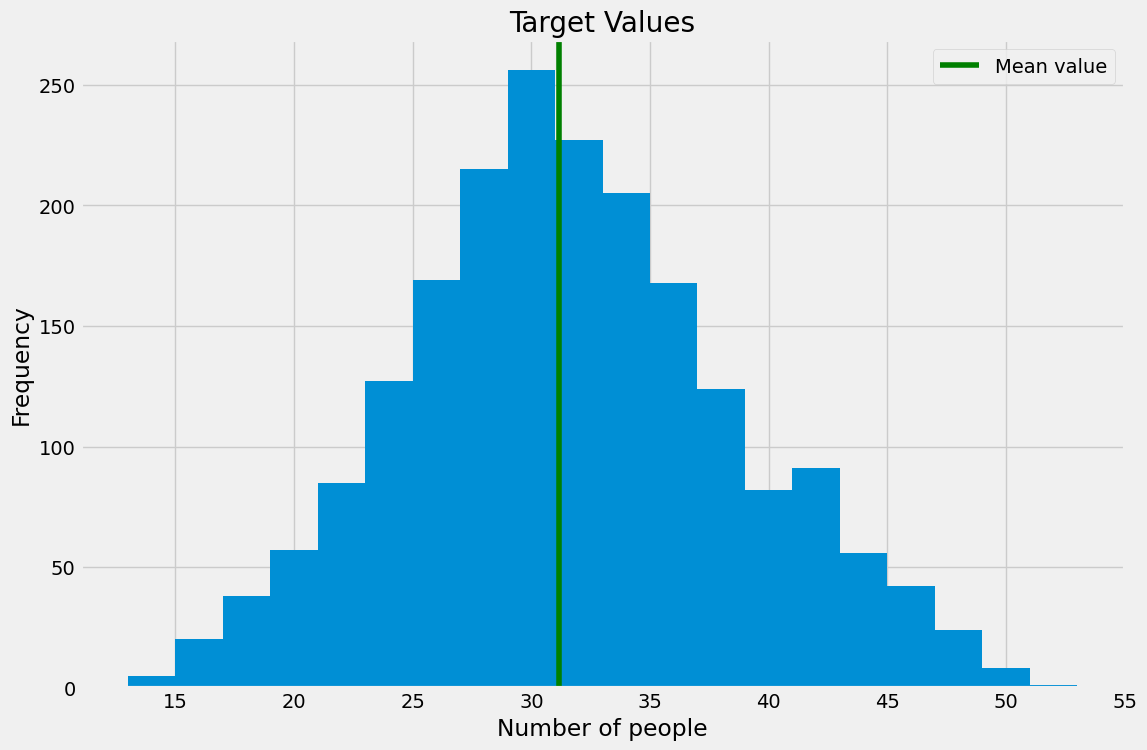

In [10]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [11]:
# Load the model.
detector = hub.load(MODEL_PATH)

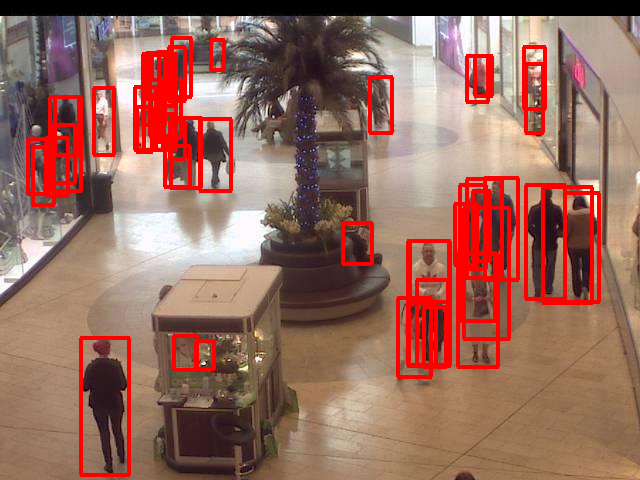

In [12]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '/content/seq_000038.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)

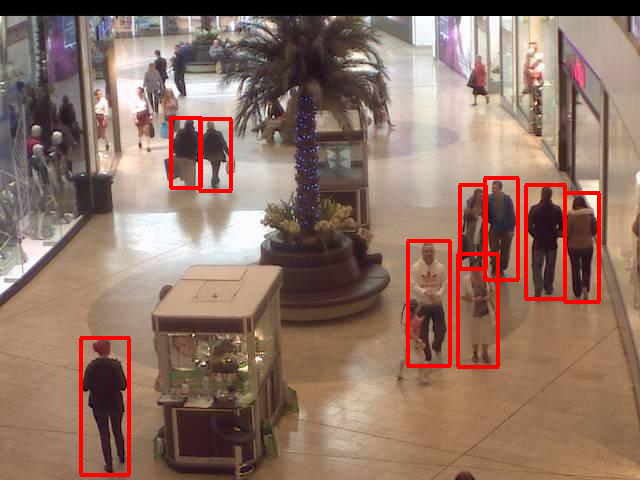

In [13]:
# With high threshold the model underestimates the number of people
# selecting only the most obvious objects at the foreground.
draw_bboxes(example_path, results, threshold=0.5)

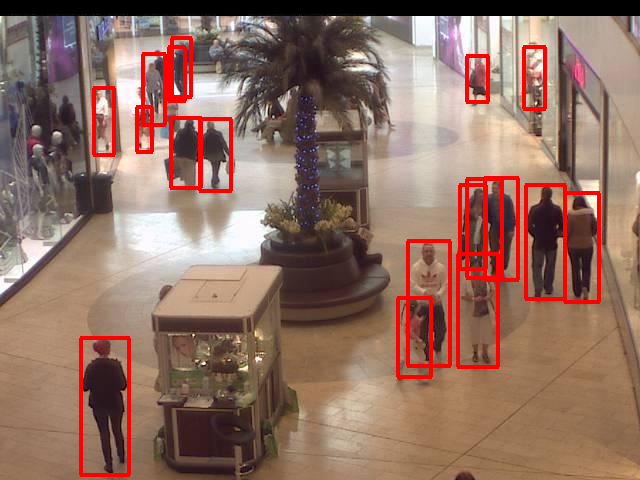

In [14]:
# With relatively low threshold the model is most accurate counting people
# that are located at the foreground and the middle of the picture.
# Objects at the background are mostly ignored.
draw_bboxes(example_path, results, threshold=0.25)

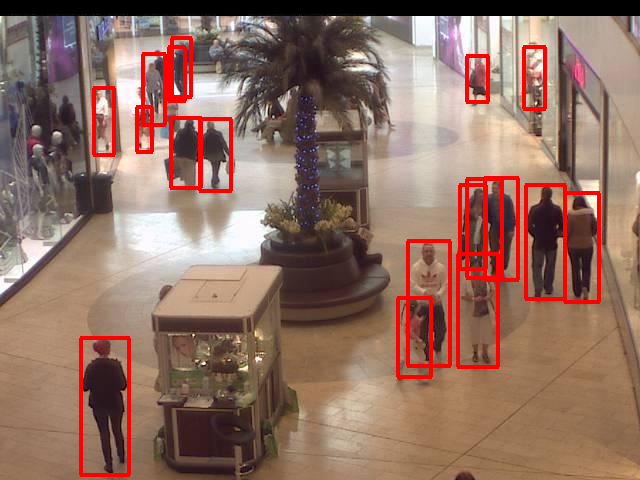

In [15]:
# Test the model on an image with small number of people.
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

/kaggle/input/crowd-counting/frames/frames/seq_000181.jpg


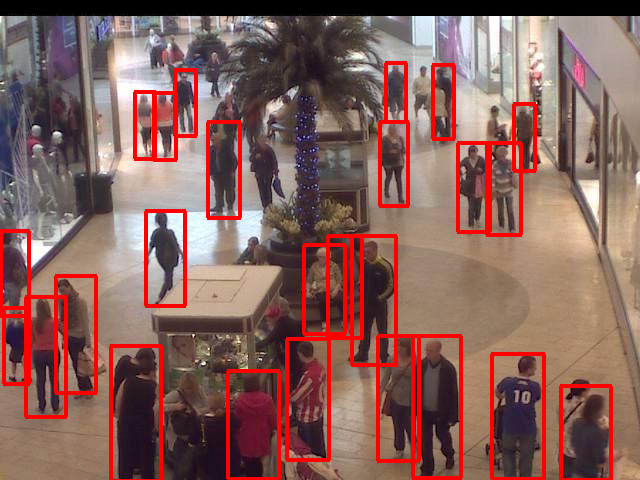

In [16]:
# Test the model on a very crowded image.
example_path = data.loc[data['count'] == data['count'].max(), 'path'].iloc[0]
print(example_path)
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

We can see that the model is not perfect and occasionally drows duplicate bounding boxes or fails to detect a person at the background or in partially occluded areas of the image.

Let's check the model on a randomly selected subset of images using predicted class 1 ("person") with confidence scores above 0.25.

In [17]:
# Performing object detection for 2,000 images takes a considerable time.
# The model processes images one at a time. Batch inference is not available.
# We can speed up the model by using multiprocessing, however it still takes a while.
# For testing purposes we will check the model performance on a randomly selected
# sample of 200 images (10% of the original data set).
sample = data.sample(frac=0.1)
start = time.perf_counter()
objects = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(count_persons, path, detector, 0.25) for path in sample['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        objects.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

200it [00:45,  4.37it/s]

Finished in 45.74 second(s).


In [18]:
# Compare predicted values with the ground truth.
sample['prediction'] = objects
sample.head(10)

,id,count,path,prediction
748,749,31,/kaggle/input/crowd-counting/frames/frames/seq...,23
455,456,23,/kaggle/input/crowd-counting/frames/frames/seq...,23
1308,1309,25,/kaggle/input/crowd-counting/frames/frames/seq...,22
1433,1434,38,/kaggle/input/crowd-counting/frames/frames/seq...,14
1278,1279,21,/kaggle/input/crowd-counting/frames/frames/seq...,15
1162,1163,34,/kaggle/input/crowd-counting/frames/frames/seq...,9
238,239,23,/kaggle/input/crowd-counting/frames/frames/seq...,16
16,17,15,/kaggle/input/crowd-counting/frames/frames/seq...,10
1890,1891,31,/kaggle/input/crowd-counting/frames/frames/seq...,21
598,599,15,/kaggle/input/crowd-counting/frames/frames/seq...,15


MAE = 12.29
MSE = 190.03


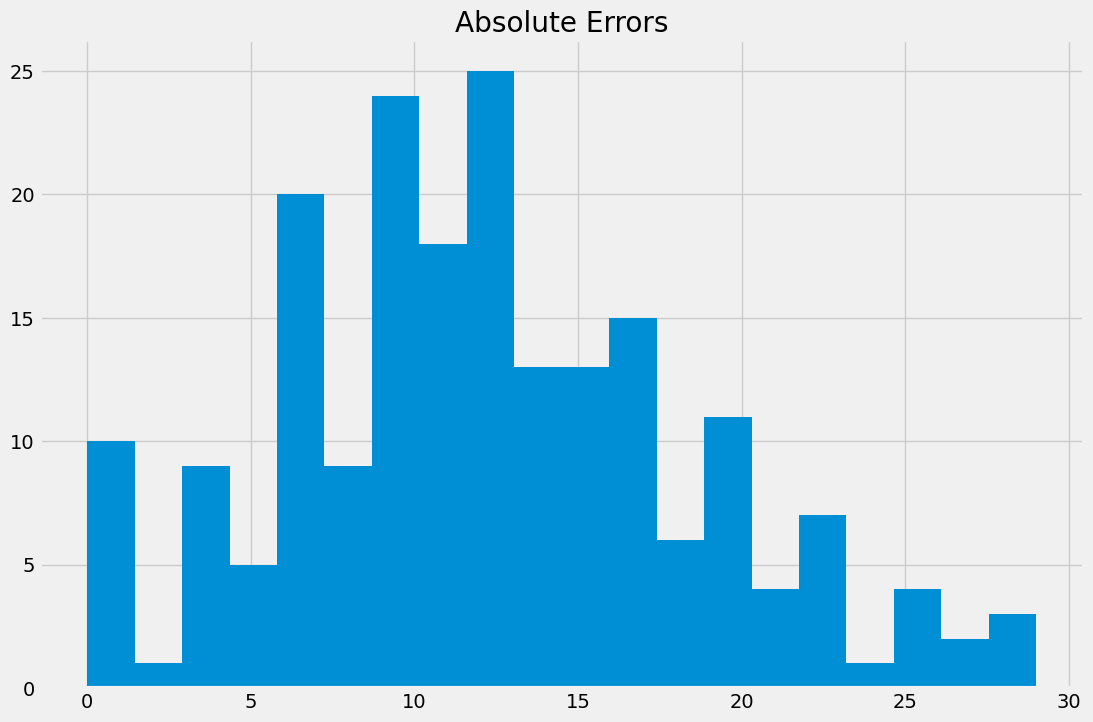

In [23]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

print(f'MAE = {sample["mae"].mean()}\nMSE = {sample["mse"].mean()}')
plt.hist(sample['mae'], bins=20)
plt.title('Absolute Errors')
plt.show()

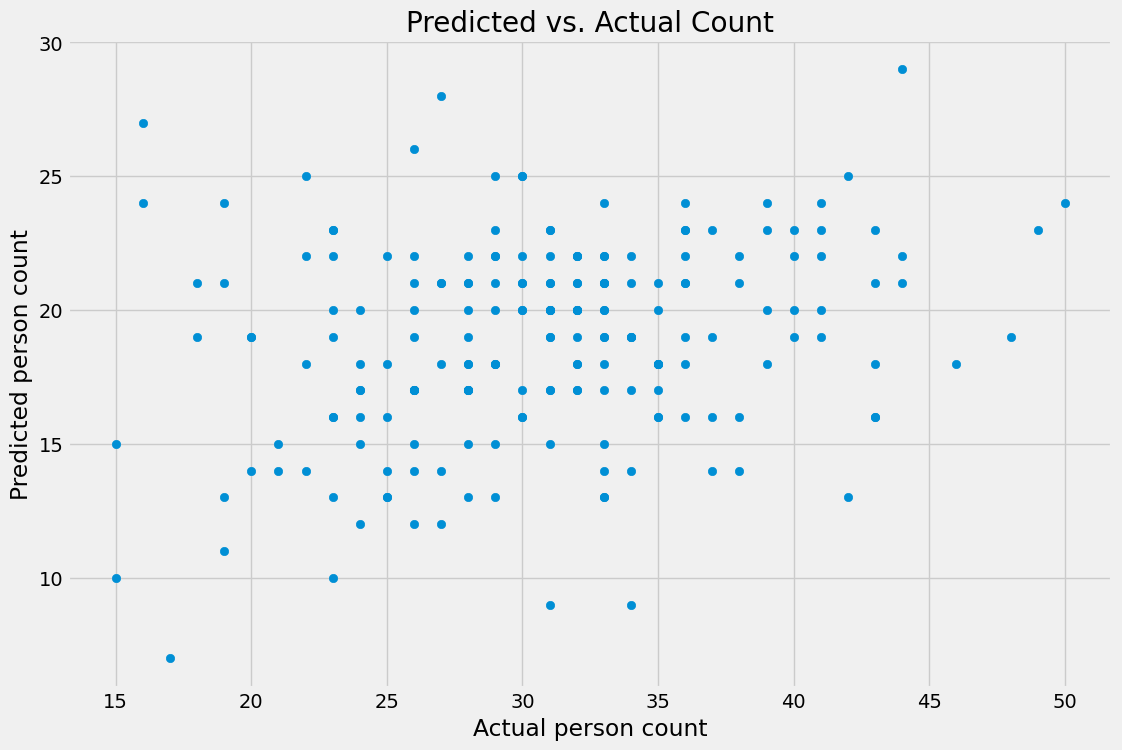

In [20]:
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel('Actual person count')
plt.ylabel('Predicted person count')
plt.title('Predicted vs. Actual Count')
plt.show()

In [27]:
tf.saved_model.save(detector, "crowd_model")

In [29]:
from google.colab import files
import os

# Define the path to the folder you want to download
folder_path = "crowd_model" # Replace with the actual path to your folder

# Compress the folder into a zip file
!zip -r /content/crowd_model.zip {folder_path}

# Download the zip file
files.download('/content/crowd_model.zip')

  adding: crowd_model/ (stored 0%)
  adding: crowd_model/assets/ (stored 0%)
  adding: crowd_model/fingerprint.pb (stored 0%)
  adding: crowd_model/variables/ (stored 0%)
  adding: crowd_model/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: crowd_model/variables/variables.index (deflated 77%)
  adding: crowd_model/saved_model.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>